In [1]:
import uproot
import numpy as np
import glob
import os
import sys
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, accuracy_score
import tensorflow.keras.backend as K
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import *
from tensorflow import keras
from tensorflow.keras import layers, models, Model
import h5py

from utils import *

np.random.seed(42)
tf.random.set_seed(42)

In [2]:
with h5py.File('HHbbbb.h5', 'r') as f:
    X_HHbbbb_isHS = f['HS'][:30000]
    X_HHbbbb_isPU = f['PU'][:30000]

with h5py.File('PJZ0.h5', 'r') as f:
    X_PJZ0 = f['data'][:30000]

print(X_HHbbbb_isHS.shape)
print(X_HHbbbb_isPU.shape)
print(X_PJZ0.shape)

(30000, 64, 50, 6)
(30000, 64, 50, 6)
(30000, 64, 50, 6)


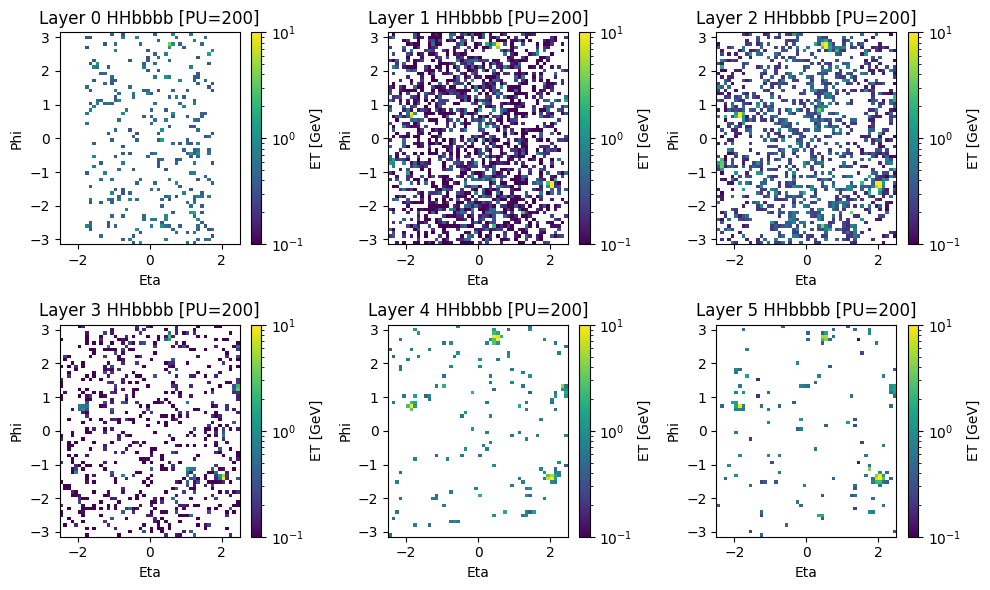

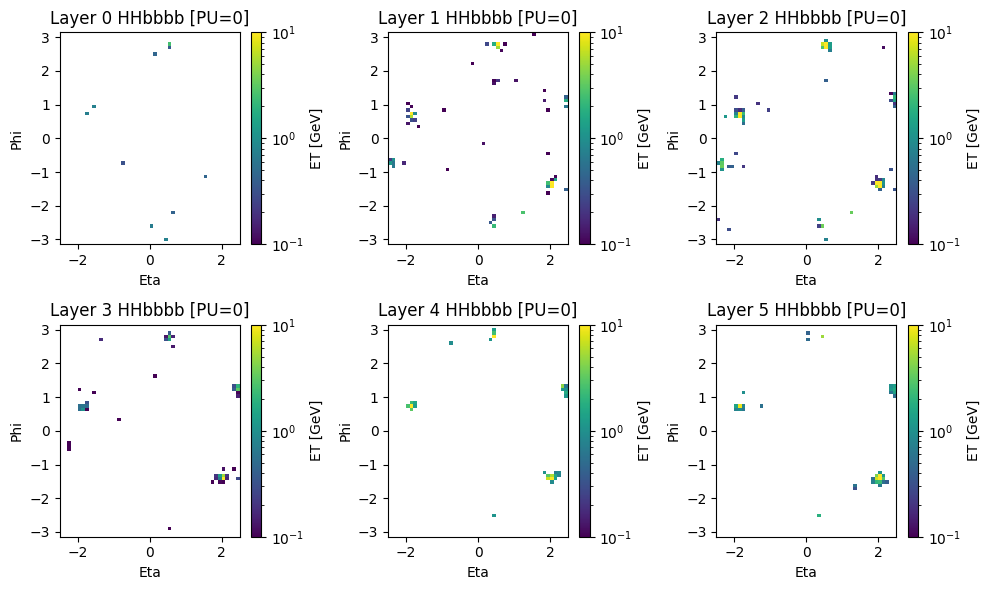

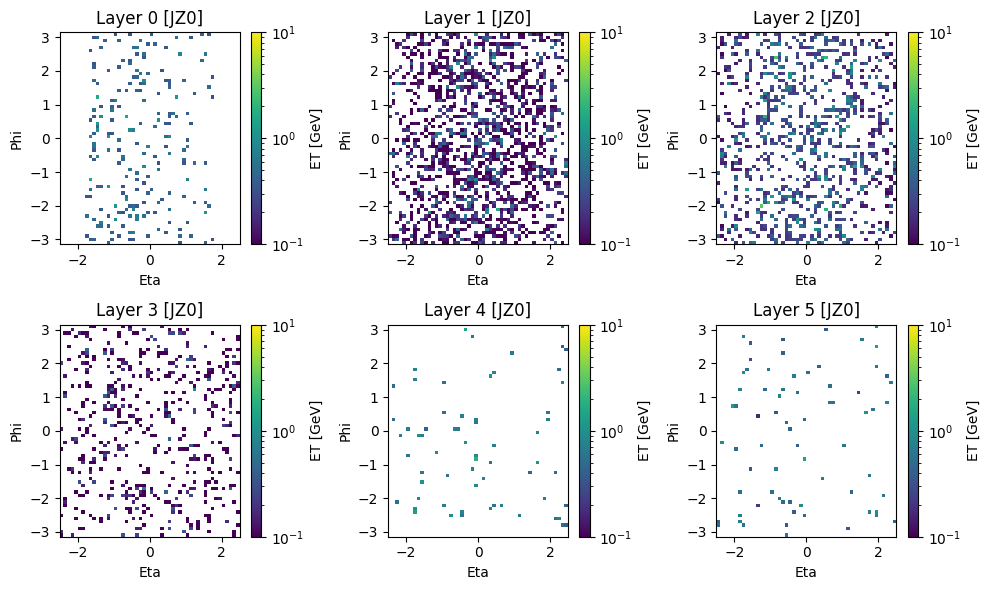

In [5]:
plot_layers(event_idx=3, X=X_HHbbbb_isHS+X_HHbbbb_isPU, label='HHbbbb [PU=200]')
plot_layers(event_idx=3, X=X_HHbbbb_isHS, label='HHbbbb [PU=0]')
plot_layers(event_idx=0, X=X_PJZ0, label='[JZ0]')